In [13]:
## NEED TO FIGURE OUT TRIANGLE.EXE for MAC!

### Getting Python Ready  
 1. Install Anaconda (Conda) Conda is an Open-source package and environment management system that runs on Windows, macOS, and Linux. (https://www.anaconda.com/download)

2. Install VS Code Visual Studio Code (VS Code) is a free, cross-platform code editor developed by Microsoft. It is designed to provide a streamlined and efficient coding experience for developers working on various platforms, including Windows, macOS, and Linux. (https://code.visualstudio.com/Download)


### Setting up your environment  

1. In Anaconda Prompt (or Terminal for Mac) set up a new environment:
 
conda create -–name gwmodelling  
conda activate gwmodelling  
conda install -c conda-forge flopy ipython ipykernel scipy openpyxl shapely geopands ninja    

2. Add Python extension in VS Code.

3. Open folder in VS code and go!


### PEST Example using MF6

In [14]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon, LineString
import flopy
from flopy.discretization import VertexGrid
from flopy.utils.triangle import Triangle as Triangle
from flopy.utils.voronoi import VoronoiGrid
%matplotlib inline
from collections import OrderedDict
import pyemu

import utils
import preprocessing

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Set up project paths

In [15]:
triExeName = '../exe/triangle.exe'
mf6ExeName = '../exe/mf6.exe'
modelname = 'pest_example'
# For this example, we will set up a model workspace.
# Model input files and output files will reside here.
workspace = '../modelfiles/'
if not os.path.exists(workspace):
    os.makedirs(workspace)
results = '../results/'
figures = '../figures/'

### Discretisation

In [16]:
# Discretisation - PLAN
Lx = 4000.
Ly = 4000.

model_boundary = [(0, 0),(Lx,0), (Lx,Ly), (0, Ly)]
model_boundary_poly = Polygon(model_boundary)

tri = Triangle(angle=32, model_ws=workspace, exe_name=triExeName)
tri.add_polygon(model_boundary)
tri.add_region((1000,200),0,maximum_area=50000) 
tri.build()
cell2d = tri.get_cell2d()     # cell info: id,x,y,nc,c1,c2,c3 (list of lists)
vertices = tri.get_vertices()
xcyc = tri.get_xcyc()   
ncpl = len(cell2d) # number of cells in plan

In [17]:
# Discretisation - SECTION

nlay = 3
top = 0 * np.ones(ncpl)
botm_lay = [-50, -100, -200]
botm = np.zeros((nlay, ncpl))
botm[0,:] = botm_lay[0] * np.ones(ncpl)
botm[1,:] = botm_lay[1] * np.ones(ncpl)
botm[2,:] = botm_lay[2] * np.ones(ncpl)

vgrid = flopy.discretization.VertexGrid(vertices=vertices, cell2d=cell2d, 
                                             ncpl = len(cell2d), nlay = nlay,
                                             top = top, botm = botm)  
gi = flopy.utils.GridIntersect(vgrid)


class Mesh:
    def __init__(self, cell2d, vertices, xcyc, nlay, ncpl, top, botm, vgrid, *args, **kwargs):     
        self.cell2d = cell2d
        self.vertices = vertices
        self.xcyc = xcyc
        self.nlay = nlay
        self.ncpl = ncpl
        self.top = top
        self.botm = botm
        self.vgrid = vgrid

mesh = Mesh(cell2d, vertices, xcyc, nlay, ncpl, top, botm, vgrid)
# For Voronoi:
#vor = VoronoiGrid(tri)
#vertices = vor.get_disv_gridprops()['vertices']
#cell2d = vor.get_disv_gridprops()['cell2d']
#xcyc = []
#for cell in cell2d:
#    xcyc.append((cell[1],cell[2]))

Text(0.5, 1.0, 'Mesh, ncell = 508')

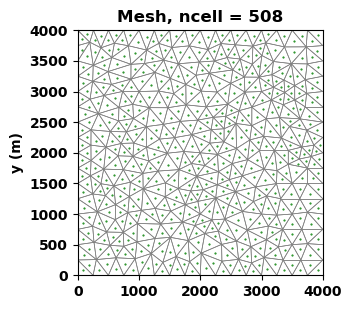

In [18]:
fig = plt.figure(figsize=(5, 7))
ax = plt.subplot(2, 1, 1, aspect='equal')
tri.plot(edgecolor='gray', lw=0.5, ax=ax)
for i in xcyc: 
    ax.plot(i[0], i[1], 'o', color = 'green', ms = 0.5)  
ax.set_ylabel('y (m)')
ax.set_title(f'Mesh, ncell = {len(cell2d)}')

### Identify important cells

In [19]:
# K zones
class Zones:
    def __init__(self, name, coords, *args, **kwargs):     
        self.name = name
        self.coords = coords
        self.polygon = Polygon(coords)

zone1 = [(0, 0),(800,0), (800,4000), (0, 4000)]
zone2 = [(800, 0),(1600,0), (1600,4000), (800, 4000)]
zone3 = [(1600, 0),(2400,0), (2400,4000), (1600, 4000)]
zone4 = [(2400, 0),(3200,0), (3200,4000), (2400, 4000)]
zone5 = [(3200, 0),(4000,0), (4000,4000), (3200, 4000)]

zones = [Zones('z1', zone1), Zones('z2', zone2), Zones('z3', zone3), Zones('z4', zone4), Zones('z5', zone5)]
for zone in zones:
    cells = gi.intersects(zone.polygon)["cellids"]
    zone.cells = cells

array_kzones = np.zeros((nlay, ncpl))
for z, zone in enumerate(zones):
    for icpl in zone.cells:
        array_kzones[:, icpl] = z

In [20]:
# East head boundary
chd1 = [(Lx, 0), (Lx, Ly)]
chd1_ls = LineString(chd1)
chd1_cells = gi.intersects(chd1_ls)["cellids"]

array_chd = np.zeros((nlay, ncpl))
for icpl in chd1_cells:
    array_chd[:, icpl] = 1

# Recharge
rch_coords = [(0, 0),(Lx,0), (Lx,Ly), (0, Ly)]
rch_poly = Polygon(rch_coords)
rch_cells = gi.intersects(rch_poly)["cellids"]

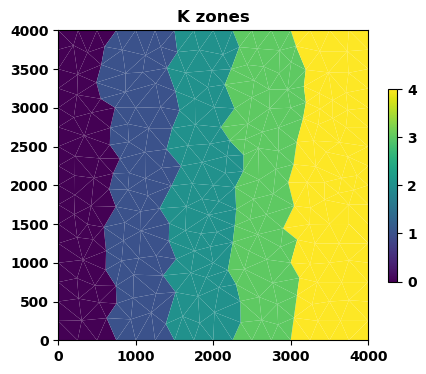

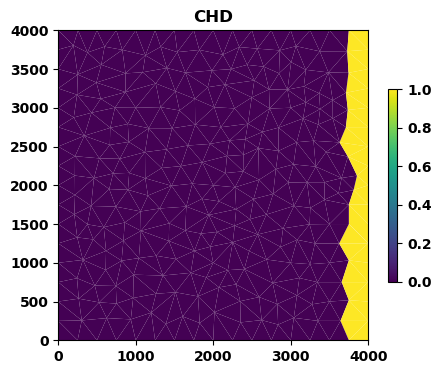

In [21]:
preprocessing.plot_array(vgrid, array = array_kzones, title = 'K zones')
preprocessing.plot_array(vgrid, array = array_chd, title = 'CHD')

### Set up parameters

In [22]:
# Time discretisation
perioddata=[(1., 1, 1.0),] # Steady state

# Hydraulic conductivity and Ss
hk = [10.,20., 30., 40., 50.] # Kh per zone
vk = [1., 1., 1., 1., 1.] # Kv per zone

# Storativity
sy = 0.2
ss = 0.0001

# Specified head boundaries
chd = 0.
chd_rec = []
for lay in range(nlay):
    for icpl in chd1_cells: 
        chd_rec.append([(lay, icpl), chd])
chd_spd = {}
chd_spd[0] = chd_rec

# Recharge
rch = 0.001

# Initial conditions
ic_global = 0.

##### Prepare Well (WEL) package

In [23]:
pumping_df = pd.read_excel('../data/bores.xlsx', sheet_name='pumping')
well_gdf = preprocessing.make_well_gdf(pumping_df, vgrid, top, botm)
well_gdf

,id,x,y,z,period,rate,geometry,icpl,ground,model_bottom,z-bot,cell_disv,"(lay,icpl)",lay,wellcell_xy,wellcell_z,well_zpillar
0,B1,850,3550,-20,1,-1000,POINT (850 3550),504,0.0,-200.0,180.0,504,"(0, 504)",0,"(750.4193804712098, 3582.0123861449315)",-25.0,"[-25.0, -75.0, -150.0]"
1,B2,1850,1350,-30,1,-1000,POINT (1850 1350),126,0.0,-200.0,170.0,126,"(0, 126)",0,"(1853.2931554679224, 1245.5354184261096)",-25.0,"[-25.0, -75.0, -150.0]"
2,B3,350,2450,-110,1,-2000,POINT (350 2450),402,0.0,-200.0,90.0,1418,"(2, 402)",2,"(361.33224498936386, 2453.6950832795437)",-150.0,"[-25.0, -75.0, -150.0]"
3,B4,650,150,-150,1,-2000,POINT (650 150),329,0.0,-200.0,50.0,1345,"(2, 329)",2,"(625.0, 95.41913414294834)",-150.0,"[-25.0, -75.0, -150.0]"


In [24]:
well_spd = {}
for period in well_gdf['period'].unique():
    # Select rows for this period and convert to list of tuples (lay, icpl, rate)
    wells = well_gdf[well_gdf['period'] == period]
    well_list = [[(row.lay, row.icpl), row.rate] for _, row in wells.iterrows()]
    well_spd[period-1] = well_list # Put in zero based


##### Prepare Observations (OBS) package

In [25]:
obs_df = pd.read_excel('../data/bores.xlsx', sheet_name='observation')
obs_gdf = preprocessing.make_obs_gdf(obs_df, vgrid)
obs_gdf
obs_recarray = preprocessing.make_obs_recarray(obs_gdf)
obs_recarray

[['OBS1', 'head', (0, 395)],
 ['OBS2', 'head', (0, 280)],
 ['OBS3', 'head', (0, 403)],
 ['OBS4', 'head', (0, 334)],
 ['OBS5', 'head', (0, 245)],
 ['OBS6', 'head', (1, 165)],
 ['OBS7', 'head', (1, 360)],
 ['OBS8', 'head', (1, 91)],
 ['OBS9', 'head', (2, 377)],
 ['OBS10', 'head', (2, 420)],
 ['OBS11', 'head', (2, 227)],
 ['OBS12', 'head', (2, 497)]]

### Write the packages

In [26]:
# Fixed parameters
class Inputs:
    def __init__(self, modelname, workspace, mf6ExeName, vgrid, perioddata, *args, **kwargs):     
        self.modelname = modelname  
        self.workspace = workspace
        self.mf6ExeName = mf6ExeName
        self.vgrid = vgrid
        self.perioddata = perioddata

inputs = Inputs(modelname, workspace, mf6ExeName, vgrid, perioddata)
inputs.chd_spd = chd_spd
inputs.well_spd = well_spd
inputs.obs_rec = obs_recarray
inputs.ic_global = ic_global

In [27]:
# Parameters - need calibration
class Parameters:
    def __init__(self, hk, vk, rch):     
        self.hk = hk
        self.vk = vk
        self.rch = rch

parameters = Parameters(hk, vk, rch)

In [28]:
def write_model(mesh, inputs, parameters):

    # Assign k11, k22, k33 using np.take and array_kzones
    k11 = np.take(parameters.hk, array_kzones.astype(int))
    k22 = np.take(parameters.hk, array_kzones.astype(int))
    k33 = np.take(parameters.vk, array_kzones.astype(int))

    rch_rec = []
    for lay in range(inputs.vgrid.nlay):
        for icpl in rch_cells: rch_rec.append([(lay, icpl), parameters.rch])
    
    rch_spd = rch_rec
    rch_spd = {}
    rch_spd[0] = rch_rec

    print('rch spd ', rch_spd)
    print('well spd ', inputs.well_spd)
    print('chd spd', inputs.chd_spd)

    sim = flopy.mf6.MFSimulation(sim_name='sim', exe_name=inputs.mf6ExeName, version='mf6', sim_ws=inputs.workspace)
    tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim) 
    gwf = flopy.mf6.ModflowGwf(sim, modelname=inputs.modelname, save_flows=True)
    ims = flopy.mf6.ModflowIms(sim, print_option='SUMMARY', complexity='complex', outer_dvclose=1.e-6, inner_dvclose=1.e-6)
    disv = flopy.mf6.ModflowGwfdisv(gwf, length_units='METERS',
                                    nlay = mesh.nlay, ncpl=mesh.ncpl, nvert=len(mesh.vertices),
                                    top = mesh.top, botm = mesh.botm, 
                                    vertices = mesh.vertices, cell2d  =mesh.cell2d)
    npf = flopy.mf6.ModflowGwfnpf(gwf, k=k11, k22=k22, k33=k33, save_flows=True)
    ic = flopy.mf6.ModflowGwfic(gwf, strt=inputs.ic_global)
    chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data = inputs.chd_spd, save_flows=True)
    rch = flopy.mf6.modflow.mfgwfrch.ModflowGwfrch(gwf, maxbound = len(rch_spd), stress_period_data = rch_spd,)
    #sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(gwf, storagecoefficient=None, 
    #                                                    iconvert=1,#inputs.iconvert, 
    #                                                    ss = inputs.ss, 
    #                                                    sy = inputs.sy,
    #                                                    steady_state={0: True},
    #                                                    transient={1: True, 2: True},)
    #wel = flopy.mf6.ModflowGwfwel(gwf, stress_period_data = inputs.well_period_data)
    csv_file = inputs.modelname + "_observations.csv" # To write observation to
    obs = flopy.mf6.ModflowUtlobs(gwf, 
                                  filename=inputs.modelname, print_input=True, 
                                  continuous={csv_file: inputs.obs_rec},) 
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord='{}.cbc'.format(inputs.modelname),
                                head_filerecord='{}.hds'.format(inputs.modelname),
                                saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                                printrecord=[('HEAD', 'LAST'), ('BUDGET', 'LAST')])
    sim.write_simulation(silent = False) 
    return sim

In [29]:
def rewrite_model(gwf, parameters):
    
    # Re-write recharge
    rec = []
    for icpl in range(ncpl): rec.append((icpl, parameters.rch))      
    rch_rec = {}      
    rch_rec[0] = rec

    # Assign k11, k22, k33 using np.take and array_kzones
    k11 = np.take(parameters.hk, array_kzones.astype(int))
    k22 = np.take(parameters.hk, array_kzones.astype(int))
    k33 = np.take(parameters.vk, array_kzones.astype(int))

    # Rewrite packages
    gwf.rch.stress_period_data = rch_rec
    gwf.rch.write()

    gwf.npf.k = k11
    gwf.npf.k22 = k22
    gwf.npf.k33 = k33
    gwf.npf.write()

In [30]:
def run_model(sim):
    success, buff = sim.run_simulation(silent = False) 

In [31]:
sim = write_model(mesh, inputs, parameters)

rch spd  {0: [[(0, 1), 0.001], [(0, 114), 0.001], [(0, 435), 0.001], [(0, 323), 0.001], [(0, 433), 0.001], [(0, 314), 0.001], [(0, 118), 0.001], [(0, 432), 0.001], [(0, 218), 0.001], [(0, 315), 0.001], [(0, 342), 0.001], [(0, 326), 0.001], [(0, 470), 0.001], [(0, 339), 0.001], [(0, 327), 0.001], [(0, 507), 0.001], [(0, 340), 0.001], [(0, 344), 0.001], [(0, 338), 0.001], [(0, 341), 0.001], [(0, 325), 0.001], [(0, 329), 0.001], [(0, 332), 0.001], [(0, 337), 0.001], [(0, 333), 0.001], [(0, 331), 0.001], [(0, 330), 0.001], [(0, 324), 0.001], [(0, 336), 0.001], [(0, 321), 0.001], [(0, 356), 0.001], [(0, 471), 0.001], [(0, 335), 0.001], [(0, 343), 0.001], [(0, 350), 0.001], [(0, 469), 0.001], [(0, 346), 0.001], [(0, 411), 0.001], [(0, 412), 0.001], [(0, 420), 0.001], [(0, 302), 0.001], [(0, 345), 0.001], [(0, 328), 0.001], [(0, 320), 0.001], [(0, 322), 0.001], [(0, 334), 0.001], [(0, 348), 0.001], [(0, 352), 0.001], [(0, 421), 0.001], [(0, 349), 0.001], [(0, 313), 0.001], [(0, 418), 0.001], 

In [32]:
run_model(sim)

FloPy is using the following executable to run the model: ..\exe\mf6.exe
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                  VERSION 6.5.0.dev0 (preliminary) 01/29/2024
                               ***DEVELOP MODE***

   MODFLOW 6 compiled Jan 29 2024 03:01:13 with Intel(R) Fortran Intel(R) 64
   Compiler Classic for applications running on Intel(R) 64, Version 2021.7.0
                             Build 20220726_000000

This software is preliminary or provisional and is subject to 
revision. It is being provided to meet the need for timely best 
science. The software has not received final approval by the U.S. 
Geological Survey (USGS). No warranty, expressed or implied, is made 
by the USGS or the U.S. Government as to the functionality of the 
software and related material nor shall the fact of release 
constitute any such warranty. The software is provided on the 
condition that neither the USGS nor the U.

### Post-processing of model results

In [33]:
# Import results
fname = os.path.join(inputs.workspace, inputs.modelname + '.hds')
hds = flopy.utils.binaryfile.HeadFile(fname)
heads = hds.get_data(idx = -1)

np.set_printoptions(precision=2)
#Print statistics
print('  min: ', heads.min())
print('  max: ', heads.max())
print(heads.shape)
print(mesh.botm.shape)

  min:  0.0
  max:  3.3272857612251094
(3, 1, 508)
(3, 508)


### Plot model results

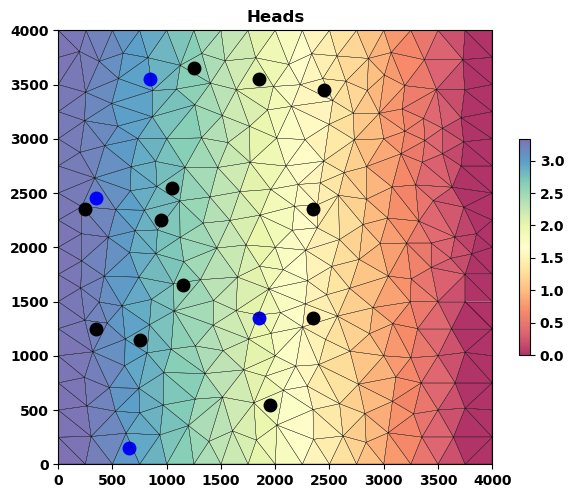

In [34]:
# This chunk is to get ready for contouring
from scipy.interpolate import griddata
x, y = mesh.xcyc[:,0], mesh.xcyc[:,1]
xG = np.linspace(x.min(), x.max(), 100)
yG = np.linspace(y.min(), y.max(), 100)
X, Y = np.meshgrid(xG, yG)

# Look how we can make a plotting function and use it many times
def plot_head(array, mesh, title, vmin = None, vmax = None):
    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(1, 1, 1, aspect='equal')
    ax.plot(obs_gdf.x, obs_gdf.y, 'o', color = 'black', markersize = 9)
    ax.plot(well_gdf.x, well_gdf.y, 'o', color = 'blue', markersize = 9)
    mapview = flopy.plot.PlotMapView(modelgrid=mesh.vgrid, ax=ax)#, layer = layer)
    plan = mapview.plot_array(a = array, cmap='Spectral', alpha=0.8, vmin = vmin, vmax = vmax)
    mapview.plot_grid(lw = 0.2, color = 'black') 

    Ti = griddata((x, y), array, (X, Y), method='cubic')
    levels = np.arange(50,90,2)
    CS = ax.contour(X,Y,Ti,levels,colors='Blue', linewidths=1.0)
    ax.clabel(CS, inline=1, fontsize=10, fmt='%1.1f')

    ax.set_title(title)
    plt.colorbar(plan, shrink = 0.4)


plot_head(heads[0,0,:], mesh, title = 'Heads')

### Plot observations in time

In [35]:
csv_file = inputs.modelname + "_observations.csv" # To write observation to
df = pd.read_csv(os.path.join(workspace, csv_file))
with open('../modelfiles/observations.txt', 'w') as f:
    for value in df.iloc[0]:
        f.write(str(value) + '\n')
print('Observations written as a list to ../modelfiles/observations.txt')

Observations written as a list to ../modelfiles/observations.txt


#### Getting PEST setup

##### Pickling what we need for many simulations

In [36]:
import pickle
with open('../modelfiles/mesh.pkl', 'wb') as f:
	pickle.dump(mesh, f)
	
with open('../modelfiles/inputs.pkl', 'wb') as f:
	pickle.dump(inputs, f)

##### Parameters

In [37]:
# CREATE TPL
pars_df = pd.read_excel('../pest/parameter_info.xlsx', sheet_name = 'pars')
pyemu.utils.helpers.simple_tpl_from_pars(pars_df.parnme.tolist(), 
                                         tplfilename='../pest/parameters.tpl', 
                                         out_dir='../pest')

##### Observations

In [38]:
# Add info to obs_gdf
obs_gdf['obsnme']= obs_gdf.apply(lambda row: f'{row['id']}', axis=1)
obs_gdf['obgnme'] = 'caldd' # add observation group
obs_gdf['weight'] = 5. # weighting
obs_gdf.rename(columns={'drawdown': 'obsval'}, inplace=True)
#obs_gdf

pyemu.utils.helpers.simple_ins_from_obs(obsnames = obs_gdf.obsnme.tolist(), 
                                        insfilename='../pest/observations.ins', 
                                        out_dir='../pest')


##### Control file

In [39]:
import pyemu

# Define the basic components of the PEST control file
tpl_files = ['../pest/parameters.tpl']  # Template files
ins_files = ['../pest/observations.ins']  # Instruction files
par_files = ['../pest/parameters.par']  # Parameter files
obs_files = ['../pest/observations.txt']  # Observation files

# Create a Pst object (PEST control file object)
pst = pyemu.Pst.from_io_files(
    tpl_files=tpl_files,
    in_files=par_files,
    ins_files=ins_files,
    out_files=obs_files,
    pst_path="../pest/"
)
# Add parameter dataframe
pst.parameter_data = pd.read_excel('../pest/parameter_info.xlsx', sheet_name = 'pars')

# Add observation dataframe
pst.observation_data = obs_gdf

# Add model command line
pst.model_command = ["runmodel.py"]  # Model command to run

# Set control data (optional, adjust as needed)
#pst.control_data.noptmax = 10  # Number of optimization iterations
#pst.control_data.relparmax = 1.5  # Maximum relative parameter change

c:\Users\00105295\AppData\Local\anaconda3\envs\gwmodelling\Lib\site-packages\pyemu\pst\pst_utils.py:914: UserWarning: error processing instruction file ../pest/observations.ins, trying inschek: output file '../pest/observations.txt' not found


In [49]:
pst.observation_data

,id,x,y,z,obsval,geometry,icpl,ground,model_bottom,z-bot,cell_disv,"(lay,icpl)",lay,obscell_xy,obscell_z,obs_zpillar,obsnme,obgnme,weight
0,OBS1,1050,2550,-40,0.305,POINT (1050 2550),395,0.0,-200.0,160.0,395,"(0, 395)",0,"(1066.1474805693624, 2574.632688843268)",-25.0,"[-25.0, -75.0, -150.0]",OBS1,caldd,5.0
1,OBS2,1850,3550,-35,0.229,POINT (1850 3550),280,0.0,-200.0,165.0,280,"(0, 280)",0,"(1815.049607145329, 3560.586374318919)",-25.0,"[-25.0, -75.0, -150.0]",OBS2,caldd,5.0
2,OBS3,250,2350,-45,0.271,POINT (250 2350),403,0.0,-200.0,155.0,403,"(0, 403)",0,"(402.71601423564175, 2271.747494319016)",-25.0,"[-25.0, -75.0, -150.0]",OBS3,caldd,5.0
3,OBS4,750,1150,-45,0.116,POINT (750 1150),334,0.0,-200.0,155.0,334,"(0, 334)",0,"(758.7025418640333, 1155.0187739788619)",-25.0,"[-25.0, -75.0, -150.0]",OBS4,caldd,5.0
4,OBS5,2350,2350,-10,0.092,POINT (2350 2350),245,0.0,-200.0,190.0,245,"(0, 245)",0,"(2317.9676510593804, 2316.6144324126326)",-25.0,"[-25.0, -75.0, -150.0]",OBS5,caldd,5.0
5,OBS6,2450,3450,-80,0.088,POINT (2450 3450),165,0.0,-200.0,120.0,673,"(1, 165)",1,"(2399.5532462859396, 3468.4153901146906)",-75.0,"[-25.0, -75.0, -150.0]",OBS6,caldd,5.0
6,OBS7,1150,1650,-90,0.277,POINT (1150 1650),360,0.0,-200.0,110.0,868,"(1, 360)",1,"(1147.001244348818, 1592.1513338395089)",-75.0,"[-25.0, -75.0, -150.0]",OBS7,caldd,5.0
7,OBS8,1950,550,-65,0.156,POINT (1950 550),91,0.0,-200.0,135.0,599,"(1, 91)",1,"(1964.723677149349, 536.5812289024334)",-75.0,"[-25.0, -75.0, -150.0]",OBS8,caldd,5.0
8,OBS9,950,2250,-120,1.015,POINT (950 2250),377,0.0,-200.0,80.0,1393,"(2, 377)",2,"(943.1219420733914, 2309.6464332934934)",-150.0,"[-25.0, -75.0, -150.0]",OBS9,caldd,5.0
9,OBS10,350,1250,-190,1.449,POINT (350 1250),420,0.0,-200.0,10.0,1436,"(2, 420)",2,"(338.60569833541666, 1221.7603030387622)",-150.0,"[-25.0, -75.0, -150.0]",OBS10,caldd,5.0


In [41]:
#pst.pestpp_options
#pst.control_data.formatted_values

In [42]:
control_df = pd.read_excel('../pest/parameter_info.xlsx', sheet_name = 'control')
control_df['value'] = control_df['value'].astype(str) # Ensure all values are strings
pst.pestpp_options = dict(zip(control_df['key'], control_df['value']))

# changes the value for the PEST++ option 'ies_parameter_ensemble'
pst.pestpp_options['ies_parameter_ensemble'] = 'dummy_ies_par_ensemble.csv'

# pestpp-ies; the number of realizations to draw in order to form parameter and observation ensembles.
pst.pestpp_options['ies_num_reals'] = 50

# specifies a list of values for the Marquardt lambda used in calculation of parameter upgrades. 
pst.pestpp_options["lambdas"] = [0.1, 1, 10, 100, 1000]

# pestpp-da; True/False, specify whether to use the simulated states at the end of each cycle as the initial states for the next cycle.   
pst.pestpp_options['da_use_simulated_states'] = True

pst.model_command = ["run_model.bat"]  # Model command to run

print(pst.nnz_obs_groups)
print(pst.nnz_obs, pst.npar_adj)
print(pst.adj_par_groups)


['caldd']
12 11
['hk', 'vk', 'rch']


In [ ]:
pst.control_data.noptmax = -2 # Single realisation

In [ ]:
# Write the PEST control file
pst.write('../pest/control.pst', version=2)


noptmax:-2, npar_adj:11, nnz_obs:12


#### Inspecting cool PST thigns

In [45]:
# generate covariance matrix from parameter bounds
parcov = pyemu.Cov.from_parameter_data(pst)

# generate a covariance matrix from observation data (e.g. weights):
obscov = pyemu.Cov.from_observation_data(pst)

In [46]:
pst.write_par_summary_table()
#pst.write_obs_summary_table()
pst.prior_information.head()

,pilbl,obgnme


### After running PEST

In [47]:
# After running model, can look at Phi and residuals.
pst.res.head()
pst.res.plot.scatter('measured', 'modelled')
pst.res.iloc[:10].loc[:, 'residual'].plot(kind='bar')
pst.plot(kind='1to1')
pst.phi
pst.phi_components # # observation group contributions to Phi
pst.plot(kind="phi_pie") # observation group contributions to Phi

Exception: Pst.res: could not residual file case.res or case.rei or case.base.rei or case.obs.csv

In [ ]:
# You can do this before running PEST...
# geostatistical structure for spatially varying parameters
gs = pyemu.geostats.GeoStruct(variograms=[v], transform='log') 
df = pyemu.pp_utils.pp_tpl_to_dataframe('../pest/parameters.tpl')
cov = gs.covariance_matrix(x=df.x, y=df.y, names=df.parnme)
# just for a bit of eye-candy; bright yellow indicates higher covariance.
c = plt.imshow(cov.x)
plt.colorbar(c)

In [ ]:
# generate covariance matrix from parameter bounds
parcov = pyemu.Cov.from_parameter_data(pst)

# generate a covariance matrix from observation data (e.g. weights):
obscov = pyemu.Cov.from_observation_data(pst)

print(cov.x.shape, parcov.x.shape, obscov.x.shape)
parcov.as_2d

In [ ]:
# ADJUST WEIGHTINGS

# Now, let's create the dictionary of non-zero weighted observation groups. 
# We will specify that we want each group to contribute a value of 100 to the objective function. 

balanced_groups = {grp:100 for grp in pst.nnz_obs_groups}
balanced_groups
# make all non-zero weighted groups have a contribution of 100.0
pst.adjust_weights(obsgrp_dict=balanced_groups,)

Exception: Pst.res: self.resfile ../pest/control.rei does not exist

In [ ]:
## AFTER HISTORY MATCHING
# need to adjust weights to be "real"
# see current phi and the number of non-zero observations
print(pst.phi, pst.nnz_obs)

pst.adjust_weights_discrepancy(original_ceiling=True) # default
# check the resulting phi
pst.phi

In [ ]:
dir(pyemu.Pst)

['_Pst__reset_weights',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__firstlineno__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__static_attributes__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adjust_weights_by_list',
 '_adjust_weights_by_phi_components',
 '_cast_df_from_lines',
 '_cast_prior_df_from_lines',
 '_load_version2',
 '_parse_external_line',
 '_parse_path_agnostic',
 '_parse_pestpp_line',
 '_parse_pi_par_names',
 '_read_df',
 '_read_line_comments',
 '_read_section_comments',
 '_rectify_parchglim',
 '_reset_file_paths_os',
 '_stats_mae',
 '_stats_mean',
 '_stats_nrmse',
 '_stats_rmse',
 '_stats_rss',
 '_try_load_longnames',
 '_update_control_section',
 '_write_df',
 '_write_version1',
 '_write_version2',
 'add_obse

In [ ]:
pcf
* control data
restart estimation
    10    5   0   1   1   1
    1.0e-5   1.0e-5   1.0e-5   1.0e-5   1.0e-5
    0.1      1.0e-5   1.0e-5   1.0e-5   1.0e-5
    1.0e-5   1.0e-5   1.0e-5   1.0e-5   1.0e-5

* parameter groups
pargp1 relative 0.01 0.0 switch 2.0 parabolic

* parameter data
param1 pargp1 relative 1.0 0.1 10.0 1.0 1.0
param2 pargp1 relative 2.0 0.1 10.0 1.0 1.0

* observation groups
obsgrp1

* observation data
obs1 obsgrp1 100.0 1.0
obs2 obsgrp1 200.0 1.0

* model command line
model.exe

* model input/output
input_file.tpl input_file.txt
output_file.ins output_file.txt

* prior information
pi1 1.0 * param1 + 2.0 * param2 = 300.0 1.0
Explanation of Sections
Control Data (* control data):

Specifies the control settings for the PEST run, such as the number of iterations, tolerances, and restart options.
Parameter Groups (* parameter groups):

Defines groups of parameters with shared properties, such as scaling and transformation methods.
Parameter Data (* parameter data):

Lists individual parameters, their groups, initial values, bounds, and scaling factors.
Observation Groups (* observation groups):

Groups observations for weighting and analysis purposes.
Observation Data (* observation data):

Specifies observed values, their weights, and group assignments.
Model Command Line (* model command line):

Defines the command to run the model being calibrated.
Model Input/Output (* model input/output):

Maps template files to model input files and instruction files to model output files.
Prior Information (* prior information):

Adds prior knowledge about parameter relationships or constraints.
Using This File with pyEMU
You can load and manipulate this control file using the pyEMU library in Python. Here's an example:


Copy code
import pyemu

# Load the control file
pst = pyemu.Pst("example.pst")

# Access and modify parameters
print(pst.parameter_data)
pst.parameter_data.loc["param1", "parval1"] = 5.0

# Save the modified control file
pst.write("modified_example.pst")

In [ ]:
# Explanation of Key Sections

# Control Data:

# restart: Indicates whether to restart a previous run (n for no).
# ++ ies_num_reals: Number of realizations in the ensemble (e.g., 100).
# ++ ies_lambda_mults: Multipliers for the lambda parameter in the Levenberg-Marquardt algorithm.
# ++ ies_initial_lambda: Initial lambda value.
# ++ ies_accept_phi_fac: Factor for accepting a new phi value.
# ++ ies_subset_size: Subset size for localization.
# ++ ies_verbose_level: Verbosity level for logging (higher values provide more details).
# ++ ies_save_binary: Whether to save results in binary format (y for yes).

# Parameter Groups: Defines groups of parameters with shared properties (e.g., pargroup1).

# Parameter Data: Defines individual parameters, their bounds, and group membership (e.g., param1).

# Observation Groups: Groups observations for easier management (e.g., obs_group1).

# Observation Data: Defines observations, their values, weights, and group membership (e.g., obs1).

# Model Command Line: Specifies the command to run the model (e.g., run_model.bat).

# Model Input/Output: Maps template and instruction files to model input and output files.

# Notes:
# Replace run_model.bat with the actual script or executable for your model.
# Template (.tpl) and instruction (.ins) files are used to link PEST++ with the model's input and output files.
# Adjust parameter and observation data to match your specific model setup.

# This is a basic example. Depending on your use case, you may need to include additional sections, such as prior information or regularization.
